# *Gendered Pronoun Resolution*

En el análisis de texto natural, existen oraciones complejas de entender incluso para las personas. Uno de los casos más conflictivos son los pronombres ambiguos. En 2018, se publicó un dataset junto con el paper [A Balanced Corpus of Gendered Ambiguous Pronouns](https://arxiv.org/pdf/1810.05201.pdf), donde se proponen un conjunto de textos con pronombres ambiguos con género.

El objetivo de este dataset es encontrar el nombre en el texto al que el pronombre ambiguo hace referencia.

Para ello se nos da un dataset con los siguientes campos:

* `ID`: Identificador de la frase.
* `Text`: Texto en fromato string.
* `Pronoun`: string con el pronombre ambiguo.
* `Pronoun-offset`: índice del carácter donde empieza el pronombre dentro del texto.
* `A`: string con el primer nombre candidato a hacer referencia por el pronombre.
* `A-offset`: índice del carácter donde empieza el nombre A dentro del texto.
* `A-coref`: boleano indicando si el pronombre hace referencia al nombre A.
* `B`: string con el segundo nombre candidato a hacer referencia por el pronombre.
* `B-offset`: índice del carácter donde empieza el nombre B dentro del texto.
* `B-coref`: boleano indicando si el pronombre hace referencia al nombre B.
* `URL`: web de donde se ha sacado el fragmento de texto.

## Objetivo:

Hacer una predicción de a cuál de los dos nombres marcados en cada frase hace referencia el pronombre seleccionado usando **dos modelos distintos** de PNL siguiendo el formato descrito a continuación:

* **MODELO 1**: Puede ser **cualquier modelo visto en los seminarios de PLN o en otras asignaturas**, como: Count vectorizer, HMM, Structured Perceptron, RNN, Logistic Regressor, XGBoost, etc...

    * Justificar el porqué del modelo elegido.
    * Entrenar el modelo.
    * Dar una accuracy del modelo.
    * Interpretar y explicar los resultados del modelo.
 

* **MODELO 2**: Debe ser un modelo **basado en Transformers** que incorpore el concepto de ***attention***.

    * Justificar el porqué del modelo elegido.
    * Entrenar el modelo.
    * Dar una accuracy del modelo.
    * Interpretar y explicar los resultados del modelo.    
    
    





## Libraries

In [368]:
import os
import sys

import pandas as pd
import numpy as np

import re
import contractions
import string 
import colorama
from colorama import Fore

from sklearn.metrics import classification_report


## Load data

In [449]:
print(os.listdir("./input/gap-coreference-master"))

['gap-development.tsv', 'gap-test.tsv', 'gap-validation.tsv']


In [450]:
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
GAP_DATA_FOLDER

'./input/gap-coreference-master'

In [451]:
train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test.tsv')
val_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation.tsv')

train_df = pd.read_csv(train_df_path, sep='\t') # train_df
test_df = pd.read_csv(test_df_path, sep='\t')
val_df = pd.read_csv(val_df_path, sep='\t')


## EDA

In [6]:
train_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [80]:
# check null values
train_df.isnull().sum()

Text              0
Pronoun           0
Pronoun-offset    0
A                 0
A-offset          0
B                 0
B-offset          0
A-coref           0
B-coref           0
dtype: int64

- Observamos que no hay valores nulos en el dataset. 

In [64]:
# describe the data 
train_df.describe()

,Pronoun-offset,A-offset,B-offset
count,2000.000000,2000.00000,2000.000000
mean,324.963500,239.77800,300.535500
std,98.788591,111.15768,113.226357
min,3.000000,0.00000,16.000000
25%,274.000000,179.75000,237.000000
50%,316.000000,239.00000,294.000000
75%,370.000000,301.25000,358.000000
max,1135.000000,971.00000,1098.000000


In [74]:
# Data imbalance
print(train_df["A-coref"].value_counts())

print(f"\n{train_df['B-coref'].value_counts()}")

A-coref
False    1126
True      874
Name: count, dtype: int64

B-coref
False    1075
True      925
Name: count, dtype: int64


- El desbalanceo de clases no es extremadamente pronunciado. 

In [76]:
# full naw text
raw_text = train_df["Text"]
raw_text

0       Zoe Telford -- played the police officer girlf...
1       He grew up in Evanston, Illinois the second ol...
2       He had been reelected to Congress, but resigne...
3       The current members of Crime have also perform...
4       Her Santa Fe Opera debut in 2005 was as Nuria ...
                              ...                        
1995    Faye's third husband, Paul Resnick, reported t...
1996    The plot of the film focuses on the life of a ...
1997    Grant played the part in Trevor Nunn's movie a...
1998    The fashion house specialised in hand-printed ...
1999    Watkins was a close friend of Hess' first wife...
Name: Text, Length: 2000, dtype: object

In [7]:
# Para visualizar las frases
def gap_printer2(data_df_row):
        
    text   = data_df_row["Text"]
    word_A = data_df_row["A"]
    word_B = data_df_row["B"]
    
    pronoun       = data_df_row["Pronoun"]
    pronoun_begin = data_df_row["Pronoun-offset"]
    pronoun_end   = pronoun_begin + len(pronoun)
    
    word_A_begin = data_df_row["A-offset"]
    word_A_end   = data_df_row["A-offset"] + len(word_A)
    word_B_begin = data_df_row["B-offset"]
    word_B_end   = data_df_row["B-offset"] + len(word_B)
    
    text_c = text.replace(word_A, " {} ")
    text_c = text.replace(word_B, " {} ")
    text_c = text.replace(pronoun, " {} ")
    
    word_boundaries = np.sort([word_A_begin, word_A_end, pronoun_begin, pronoun_end, word_B_begin, word_B_end])
    word_boundaries = list(zip(word_boundaries[::2], word_boundaries[1::2]))
    
    P1 = [0,word_boundaries[0][0]]
    P2 = [word_boundaries[0][1],word_boundaries[1][0]]
    P3 = [word_boundaries[1][1],word_boundaries[2][0]]
    P4 = [word_boundaries[2][1],len(text)]

    text_f = text[P1[0]:P1[1]] + "{}" + text[P2[0]:P2[1]] +  "{}" + text[P3[0]:P3[1]] + "{}" + text[P4[0]:P4[1]]
 
    print(text_f.format( Fore.BLUE  + text[word_boundaries[0][0]:word_boundaries[0][1]]  + Fore.BLACK,
                         Fore.BLUE  + text[word_boundaries[1][0]:word_boundaries[1][1]] + Fore.BLACK,
                         Fore.BLUE  + text[word_boundaries[2][0]:word_boundaries[2][1]]  + Fore.BLACK))

In [5]:
gap_printer2(train_df.loc[3])

The current members of Crime have also performed in San Francisco under the band name ''Remote Viewers``. Strike has published two works of fiction in recent years: Ports of Hell, which is listed in the Rock and Roll Hall of Fame Library, and A Loud Humming Sound Came from Above. Rank has produced numerous films (under his real name, Henry Rosenthal) including the hit The Devil and Daniel Johnston.


- El pronombre que tenemos que identificar es `his`. 
- Tenemos 2 posibles nombres a los que hace referencia: `Hell` y `Henry Rosenthal`.


In [6]:
# extraemos la URL del segundo elemento del dataset
url = train_df["URL"][1]
url

'http://en.wikipedia.org/wiki/Warren_MacKenzie'

In [8]:
# extraemos el segundo texto del dataset
text = train_df["Text"][1]
text

'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.'

In [9]:
# extraemos el primer pronombre del segundo elemento del dataset
pronoun = train_df["Pronoun"][1]
pronoun

'His'

In [10]:
# extraemos el offset del primer pronombre del segundo elemento del dataset
pronoun_offset = train_df["Pronoun-offset"][1]
pronoun_offset

284

In [11]:
# visualizamos de otra forma el pronombre. 
# A partir de la variable Text, si seleccionamos únicamente la parte que empieza
# en el pronoun offset y acaba en el pronoun offset + el tamaño de ese pronombre, 
# lo que extraemos del texto es el pronombre. 
text[pronoun_offset:pronoun_offset+len(pronoun)]

'His'

In [12]:
# Extraemos el nombre A y el A-offset
A = train_df["A"][1]
A_offset = train_df["A-offset"][1]
A, A_offset

('MacKenzie', 228)

In [13]:
# nombre A
text[A_offset:A_offset+len(A)]

'MacKenzie'

In [14]:
# nombre B y B-offset
B = train_df["B"][1]
B_offset = train_df["B-offset"][1]
B, B_offset

('Bernard Leach', 251)

In [15]:
# nombre B 
text[B_offset:B_offset+len(B)]

'Bernard Leach'

## 1st Variable Selection

Nos quedamos únicamente con las variables más interesantes: la URL no nos hace falta para un problema de procesado de texto.

In [443]:
def select_imp_features(df):
    imp_features =["Text", "Pronoun", "Pronoun-offset", "A", "A-offset", "B", "B-offset"]
    target_col = ["A-coref", "B-coref"]
    df = df[imp_features+target_col]    

In [ ]:
train_df = select_imp_features(train_df)

## Text cleaning 

### To lower case 

In [224]:
# To lower case
def lower_case(df):
    df["text_clean"] = df["Text"].apply(lambda x: x.lower())
    df["Pronoun"] = df["Pronoun"].apply(lambda x: x.lower())
    df["A"] = df["A"].apply(lambda x: x.lower())
    df["B"] = df["B"].apply(lambda x: x.lower())

    return df

In [11]:
train_df_clean = lower_case(train_df)
train_df_clean.head()

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford -- played the police officer girlf...
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,"he grew up in evanston, illinois the second ol..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,"he had been reelected to congress, but resigne..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...


### Expand the contractions: Contraction Mapping

In [12]:
def expand_contractions(df):
    df["text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))
    return df

In [13]:
train_df_clean = expand_contractions(train_df_clean)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford -- played the police officer girlfriend of simon, maggie. dumped by simon in the final episode of series 1, after he slept with jenny, and is not seen again. phoebe thomas played cheryl cassidy, pauline's friend and also a year 11 pupil in simon's class. dumped her boyfriend following simon's advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline.
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as t

### Remove non-characters and URLs 

In [14]:
def remove_non_ascii_characters(df, col='text_clean'):
    df[col] = df[col].apply(lambda text: re.sub(r'[^\x00-\x7f]', r'', text)) # get rid of non-characters and whitespace
    return df

In [15]:
train_df_clean = remove_non_ascii_characters(train_df_clean)

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford -- played the police officer girlfriend of simon, maggie. dumped by simon in the final episode of series 1, after he slept with jenny, and is not seen again. phoebe thomas played cheryl cassidy, pauline's friend and also a year 11 pupil in simon's class. dumped her boyfriend following simon's advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline.
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as t

In [16]:
def remove_punctuations(df, col='text_clean'):
    """
     - str.maketrans('', '', string.punctuation) crea un traductor utilizando maketrans 
       que mapea los caracteres de puntuación a None, es decir, los elimina.
     - string.punctuation es una cadena predefinida en el módulo string que contiene todos 
       los caracteres de puntuación.
     - text.translate(translator) aplica el traductor al texto, reemplazando las puntuaciones 
       con caracteres vacíos, lo que efectivamente las elimina.
    """
    df[col] = df[col].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    # return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return df

In [17]:
train_df_clean = remove_punctuations(train_df_clean)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford  played the police officer girlfriend of simon maggie dumped by simon in the final episode of series 1 after he slept with jenny and is not seen again phoebe thomas played cheryl cassidy paulines friend and also a year 11 pupil in simons class dumped her boyfriend following simons advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as the Vice-Chair

## Text Preprocessing 

In [ ]:
# def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):
#     tokenizer.enable_truncation(max_lenght=maxlen)
#     tokenizer.enable_padding(max_lenght=maxlen)

#     all_ids = []

#     for i in range(0, len(texts),chunk_size):
#         text_chunk = texts[i:i+chunk_size].to_list()
#         encs = tokenizer.encode_batch(text_chunk)
#         all_ids.extend([enc.ids for enc in encs])
    
#     return np.array(all_ids)


### Tokenization 

In [18]:
import nltk
nltk.download('punkt') # word_tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train_df_clean['tokenized'] = train_df_clean['text_clean'].apply(word_tokenize)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["tokenized"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["tokenized"][100])
display(train_df_clean.head())

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dumped', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoebe', 'thomas', 'played', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simons', 'class', 'dumped', 'her', 'boyfriend', 'following', 'simons', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to',

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ..."


### Stemming

In [ ]:
# probar los 3 y luego elegir en base a cuál ha dado mejores resultados

#### PorterStemmer

In [20]:
from nltk.stem import PorterStemmer

In [21]:
def porter_stemmer(text):
    """
        Stem words in list of tokenized words with PorterStemmer
    """
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [22]:
train_df_clean['porter_stemmer'] = train_df_clean['tokenized'].apply(lambda x: porter_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["porter_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["porter_stemmer"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'thi', 'wa', 'due', 'to', 'him', 'catch', 'crab', 'off

#### SnowballStemmer


In [23]:
from nltk.stem import SnowballStemmer


In [24]:
def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [25]:
train_df_clean['snowball_stemmer'] = train_df_clean['tokenized'].apply(lambda x: snowball_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["snowball_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["snowball_stemmer"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'this', 'was', 'due', 'to', 'him', 'catch', 'crab', 'o

#### LancasterStemmer 

In [26]:
from nltk.stem import LancasterStemmer

In [27]:
def lancaster_stemmer(text):
    """
        Stem words in list of tokenized words with LancasterStemmer
    """
    stemmer = nltk.LancasterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [28]:
train_df_clean['lancaster_stemmer'] = train_df_clean['tokenized'].apply(lambda x: lancaster_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["lancaster_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["lancaster_stemmer"][100])
display(train_df_clean.head())

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'pol', 'off', 'girlfriend', 'of', 'simon', 'maggy', 'dump', 'by', 'simon', 'in', 'the', 'fin', 'episod', 'of', 'sery', '1', 'aft', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidy', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'adv', 'aft', 'he', 'would', 'not', 'hav', 'sex', 'with', 'her', 'but', 'lat', 'real', 'thi', 'was', 'due', 'to', 'him', 'catch', 'crab', 'off', 'her', 'frien

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as..."


#### Comparation 

In [30]:
print(train_df_clean["Text"][0])
print("\n")
print(train_df_clean["porter_stemmer"][0])
print("\n")
print(train_df_clean["snowball_stemmer"][0])
print("\n")
print(train_df_clean["lancaster_stemmer"][0])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.


['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'thi', 'wa', 'due', 'to', 'him', 'catch', 'crab', 'o

- Según los resultados obtenidos, parece que el Porter stemmer y el Snowball stemmer producen resultados muy similares. 

- Sin embargo, el Lancaster stemmer tiende a ser más agresivo en la separación de palabras, lo que da como resultado palabras más cortas y menos reconocibles. 

- Por tanto, finalmente elegimos el Snowball stemmer, que es un poco más agresivo que el Porter stemmer pero menos agresivo que el Lancaster stemmer, y en nustro caso es el que mejor resultado ha dado. 


### Part of Speech Tagging (POS Tagging):


In [77]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [78]:
# PoS tags
train_df_clean['pos_tags'] = train_df_clean['tokenized'].apply(nltk.tag.pos_tag)

In [103]:
# double check
print("\ntokenized:")
print(train_df_clean["tokenized"][0])
print("\npos_tags:")
print(train_df_clean["pos_tags"][0])
print("\n")
print("\ntokenized:")
print(train_df_clean["tokenized"][100])
print("\npos_tags:")
print(train_df_clean["pos_tags"][100])



tokenized:
['zoe', 'telford', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dumped', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoebe', 'thomas', 'played', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simons', 'class', 'dumped', 'her', 'boyfriend', 'following', 'simons', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to', 'him', 'catching', 'crabs', 'off', 'her', 'friend', 'pauline']

pos_tags:
[('zoe', 'NN'), ('telford', 'NN'), ('played', 'VBD'), ('the', 'DT'), ('police', 'NN'), ('officer', 'NN'), ('girlfriend', 'NN'), ('of', 'IN'), ('simon', 'JJ'), ('maggie', 'NN'), ('dumped', 'VBN'), ('by', 'IN'), ('simon', 'NN'), ('in', 'IN'), ('the', 'DT'), ('final', 'JJ'), ('episode', 'NN'), ('of', 'IN'), ('series', 'NN'), ('1', 'CD'), ('a

- Ahora podemos utilizar estas etiquetas para aplicar la lematización.

### Lemmatization

- Dado que la lematización es un proceso más sofisticado que tiene en cuenta el contexto gramatical y semántico, es recomendable aplicarla después de la tokenización. Esto asegurará que las palabras se reduzcan a su forma base correcta y se conserven las relaciones léxicas y semánticas adecuadas en el texto.

#### With PoS

In [85]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Extraemos todas las etiquetas del texto: 

In [107]:
train_df_clean['pos_tags']

0       [(zoe, NN), (telford, NN), (played, VBD), (the...
1       [(he, PRP), (grew, VBD), (up, RP), (in, IN), (...
2       [(he, PRP), (had, VBD), (been, VBN), (reelecte...
3       [(the, DT), (current, JJ), (members, NNS), (of...
4       [(her, PRP$), (santa, NN), (fe, NN), (opera, N...
                              ...                        
1995    [(fayes, NNS), (third, JJ), (husband, NN), (pa...
1996    [(the, DT), (plot, NN), (of, IN), (the, DT), (...
1997    [(grant, NN), (played, VBD), (the, DT), (part,...
1998    [(the, DT), (fashion, NN), (house, NN), (speci...
1999    [(watkins, NNS), (was, VBD), (a, DT), (close, ...
Name: pos_tags, Length: 2000, dtype: object

In [109]:
def get_unique_pos_tags(df, pos_tags_col = "pos_tags"):
    # Crear una lista para almacenar todas las etiquetas
    all_tags = []

    # Iterar sobre los elementos de la columna 'pos_tags'
    for tags in df[pos_tags_col]:
        # Obtener las etiquetas de cada par (palabra, etiqueta)
        tag_list = [tag[1] for tag in tags]
        # Agregar las etiquetas a la lista general: 
            # extend() para agregar múltiples elementos a una lista
        all_tags.extend(tag_list)

    # Obtener las etiquetas únicas sin repetidos
    unique_tags = set(all_tags)

    # Imprimir las etiquetas únicas
    return unique_tags


In [111]:
# all unique tags
print(get_unique_pos_tags(train_df_clean))

{'VBZ', 'RP', 'NNP', 'POS', 'CC', 'DT', 'NN', 'VBD', 'FW', 'RBS', '$', 'VB', 'WP$', 'JJS', 'TO', 'MD', 'VBN', 'WRB', 'PRP', 'PRP$', 'RBR', 'NNS', 'WP', 'VBP', 'RB', 'PDT', 'JJ', 'IN', 'VBG', 'NNPS', 'EX', 'JJR', 'CD', 'WDT'}


Definimos una función que mapee las etiquetas POS de NLTK a las etiquetas POS de WordNet. Esto es necesario para que el lematizador pueda interpretar correctamente las etiquetas POS:

- *WordNet only contains "open-class words": nouns, verbs, adjectives, and adverbs. Thus, excluded words include determiners, prepositions, pronouns, conjunctions, and particles.*

In [129]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('POS'):
        return wordnet.NOUN
    elif tag.startswith('RB'):
        return wordnet.ADV
    elif tag.startswith('CD'):
        return wordnet.NOUN   
    
    # elif tag.startswith('RP'):
    #     return wordnet.PRT
    # elif tag.startswith('WRB'):
    #     return wordnet.WADV
    # elif tag.startswith('PR'):
    #     return wordnet.PRON 
    # elif tag.startswith('WP'):
    #     return wordnet.PRON 
    # elif tag.startswith('IN'):
    #     return wordnet.PREP
    # elif tag.startswith('CC'):
    #     return wordnet.CONJ
    # elif tag.startswith('DT'):
    #     return wordnet.DT
    # elif tag.startswith('WDT'):
    #     return wordnet.WH_DETERMINER
    # elif tag.startswith('EX'):
    #     return wordnet.EXISTENTIAL_THERE
    # elif tag.startswith('PDT'):
    #     return wordnet.PREDETERMINER
    # elif tag.startswith('TO'):
    #     return wordnet.to
    # elif tag.startswith('MD'):
    #     return wordnet.MODAL
    # elif tag.startswith('FW'):
    #     return wordnet.FOREIGN_WORD
    
    else:
        return wordnet.NOUN  # Por defecto, asumimos sustantivos si la etiqueta POS no coincide con las anteriores


In [130]:
train_df_clean['wordnet_pos'] = train_df_clean['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [132]:
train_df_clean['wordnet_pos']

0       [(zoe, n), (telford, n), (played, v), (the, n)...
1       [(he, n), (grew, v), (up, n), (in, n), (evanst...
2       [(he, n), (had, v), (been, v), (reelected, v),...
3       [(the, n), (current, a), (members, n), (of, n)...
4       [(her, n), (santa, n), (fe, n), (opera, n), (d...
                              ...                        
1995    [(fayes, n), (third, a), (husband, n), (paul, ...
1996    [(the, n), (plot, n), (of, n), (the, n), (film...
1997    [(grant, n), (played, v), (the, n), (part, n),...
1998    [(the, n), (fashion, n), (house, n), (speciali...
1999    [(watkins, n), (was, v), (a, n), (close, a), (...
Name: wordnet_pos, Length: 2000, dtype: object

Aplicamos el word lemmatizer: 

In [113]:
from nltk.stem import WordNetLemmatizer

In [133]:
def lemmatize_word_pos(text):
    """
    Lemmatize the tokenized words (with PoS)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemmatized_text

In [135]:
# With PoS
train_df_clean['lemmatize_word_pos'] = train_df_clean['wordnet_pos'].apply(lambda x: lemmatize_word_pos(x))

In [138]:
train_df_clean.head(3)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word,pos_tags,wordnet_pos,lemmatize_word_pos
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g...","[(zoe, NN), (telford, NN), (played, VBD), (the...","[(zoe, n), (telford, n), (played, v), (the, n)...","[zoe, telford, play, the, police, officer, gir..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se...","[(he, PRP), (grew, VBD), (up, RP), (in, IN), (...","[(he, n), (grew, v), (up, n), (in, n), (evanst...","[he, grow, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ...","[(he, PRP), (had, VBD), (been, VBN), (reelecte...","[(he, n), (had, v), (been, v), (reelected, v),...","[he, have, be, reelect, to, congress, but, res..."


#### Without PoS

In [114]:
def lemmatize_word(text):
    """
    Lemmatize the tokenized words (without PoS)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [ ]:
# Without PoS
train_df_clean['lemmatize_word'] = train_df_clean['tokenized'].apply(lambda x: lemmatize_word(x))

In [48]:
# double check
display(train_df_clean.head())

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,...","[the, current, member, of, crime, have, also, ..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as...","[her, santa, fe, opera, debut, in, 2005, wa, a..."


### Lemmatization with PoS vs Lemmatization without PoS

In [139]:
# double check
print("\nOriginal:")
print(train_df_clean["Text"][0])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][0])
print("\nlemmatization no PoS:")
print(train_df_clean["lemmatize_word"][0])
print("\n")
print("\nOriginal:")
print(train_df_clean["Text"][100])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][100])
print("\nlemmatization no PoS:")
print(train_df_clean["lemmatize_word"][100])


Original:
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.

lemmatization PoS:
['zoe', 'telford', 'play', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'sleep', 'with', 'jenny', 'and', 'be', 'not', 'see', 'again', 'phoebe', 'thomas', 'play', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realise', 'this', 'be

- La lematización consiste en encontrar la raíz o lema de una palabra, y el lema de una palabra puede depender de su categoría gramatical.
- Al disponer de etiquetas de PoS confiables y precisas, podemos utilizarlas para mejorar la lematización y obtener resultados más precisos.
- Observamos que la lematización con PoS da mejores resultados que sin el PoS. 
- Por tanto, nos quedamos con la lematización con PoS.

### Stemming (snowball_stemmer) vs Lemmatization with PoS

In [141]:
# double check
print("\nOriginal:")
print(train_df_clean["Text"][0])
print("\nsnowball_stemmer:")
print(train_df_clean["snowball_stemmer"][0])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][0])
print("\n")
print("\nOriginal:")
print(train_df_clean["Text"][100])
print("\nsnowball_stemmer:")
print(train_df_clean["snowball_stemmer"][100])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][100])


Original:
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.

snowball_stemmer:
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'this', 'was', 'due', 't

- Como la precisión y la coherencia lingüística son importantes en nuestro problema, la lematización puede ser más apropiada, ya que considera el contexto gramatical y semántico de las palabras. 

- Por otro lado, el stemming es un proceso más simple que busca eliminar sufijos y prefijos de las palabras para obtener una forma truncada. El stemming puede producir resultados que no corresponden a palabras reales y puede no ser tan efectivo para capturar la forma base de las palabras.

- En nuestro caso observamos que, efectivamente, la lematización con PoS funciona mejor que el stemming. 

- Por tanto, elegimos la lematización con PoS.

## Text Features Extraction



Métodos como One-Hot Encoding o Weighted Words, como Bag of Words (BoW) - Bag of n-grams, Frequency Vectors - CountVectorizer y Term Frequency-Inverse Document Frequency (TF-IDF) no capturan ni la semántica (el significado de las palabras) ni la sintáctica (posición de las palabras en el texto). Para superar estas limitaciones utilizamos los embeddings. Los embeddings captan el contexto de una palabra teniendo en cuenta las palabras vecinas en la frase y el orden de las palabras en la frase. 


### Word2Vec Embedding

Embeddings: vector based numerical representations of text.

Como tenemos un número considerable de filas (2000), usaremos embeddings, como Word2Vec. 

- Word2Vec es un encoder de tipo denso. 
- Utiliza una red neuronal
para aprender asociaciones de palabras a partir de un
texto.
- Por cada palabra, construye un vector de n dimensiones.
- En función del número de parámetros y de los datos de
entrenamiento, es capaz de capturar el significado de las
palabras y detectar sinónimos o palabras relacionadas.
- Permite calcular similitudes → cos(θ)
- Permite hacer operaciones con los vectores de
palabras.


**Ventajas:**
- Captura la posición de las palabras en el texto (sintáctica).
- Capta el significado de las palabras (semántica). 

**Limitaciones:** 
- No puede captar el significado de la palabra a partir del texto (no capta la polisemia).
- No capta las palabras del corpus que no están en el vocabulario.


#### 1a prova

In [146]:
from gensim.models import word2vec

In [157]:
# subset con las variables que nos interesan
train_df_clean_prep = train_df_clean[['Text',
                                      'Pronoun', 
                                      'Pronoun-offset', 
                                      'A', 
                                      'A-offset', 
                                      'B', 
                                      'B-offset', 
                                      'A-coref', 
                                      'B-coref', 
                                      'text_clean', 
                                      'tokenized',
                                      'lemmatize_word_pos']]
train_df_clean_prep.head(3)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,lemmatize_word_pos
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, police, officer, gir..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grow, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, have, be, reelect, to, congress, but, res..."


In [225]:
train_df_clean = lower_case(train_df_clean)
train_df_clean.head()

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word,pos_tags,wordnet_pos,lemmatize_word_pos
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford -- played the police officer girlf...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g...","[(zoe, NN), (telford, NN), (played, VBD), (the...","[(zoe, n), (telford, n), (played, v), (the, n)...","[zoe, telford, play, the, police, officer, gir..."
1,"He grew up in Evanston, Illinois the second ol...",his,284,mackenzie,228,bernard leach,251,True,False,"he grew up in evanston, illinois the second ol...","[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se...","[(he, PRP), (grew, VBD), (up, RP), (in, IN), (...","[(he, n), (grew, v), (up, n), (in, n), (evanst...","[he, grow, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,"he had been reelected to congress, but resigne...","[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ...","[(he, PRP), (had, VBD), (been, VBN), (reelecte...","[(he, n), (had, v), (been, v), (reelected, v),...","[he, have, be, reelect, to, congress, but, res..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,...","[the, current, member, of, crime, have, also, ...","[(the, DT), (current, JJ), (members, NNS), (of...","[(the, n), (current, a), (members, n), (of, n)...","[the, current, member, of, crime, have, also, ..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,she,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[(her, PRP$), (santa, NN), (fe, NN), (opera, N...","[(her, n), (santa, n), (fe, n), (opera, n), (d...","[her, santa, fe, opera, debut, in, 2005, be, a..."


- Para implementar Word2Vec, necesitaremos los textos preprocesados y tokenizados: la columna "lemmatize_word_pos"  contiene los textos lematizados y tokenizados. 
- Utilizaremos esa columna para entrenar el modelo Word2Vec.



In [159]:
import gensim
from gensim.models import Word2Vec
print("gensim version:", gensim.__version__)


gensim version: 4.3.1


In [200]:
train_df_clean

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word,pos_tags,wordnet_pos,lemmatize_word_pos
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g...","[(zoe, NN), (telford, NN), (played, VBD), (the...","[(zoe, n), (telford, n), (played, v), (the, n)...","[zoe, telford, play, the, police, officer, gir..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se...","[(he, PRP), (grew, VBD), (up, RP), (in, IN), (...","[(he, n), (grew, v), (up, n), (in, n), (evanst...","[he, grow, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ...","[(he, PRP), (had, VBD), (been, VBN), (reelecte...","[(he, n), (had, v), (been, v), (reelected, v),...","[he, have, be, reelect, to, congress, but, res..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,...","[the, current, member, of, crime, have, also, ...","[(the, DT), (current, JJ), (members, NNS), (of...","[(the, n), (current, a), (members, n), (of, n)...","[the, current, member, of, crime, have, also, ..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[(her, PRP$), (santa, NN), (fe, NN), (opera, N...","[(her, n), (santa, n), (fe, n), (opera, n), (d...","[her, santa, fe, opera, debut, in, 2005, be, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"Faye's third husband, Paul Resnick, reported t...",her,433,nicole,255,faye,328,False,True,fayes third husband paul resnick reported that...,"[fayes, third, husband, paul, resnick, reporte...","[fay, third, husband, paul, resnick, report, t...","[fay, third, husband, paul, resnick, report, t...","[fay, third, husband, paul, resnick, report, t...","[fayes, third, husband, paul, resnick, reporte...","[(fayes, NNS), (third, JJ), (husband, NN), (pa...","[(fayes, n), (third, a), (husband, n), (paul, ...","[fayes, third, husband, paul, resnick, report,..."
1996,The plot of the film focuses on the life of a ...,her,246,doris chu,111,mei,215,False,True,the plot of the film focuses on the life of a ...,"[the, plot, of, the, film, focuses, on, the, l...","[the, plot, of, the, film, focus, on, the, lif...","[the, plot, of, the, film, focus, on, the, lif...","[the, plot, of, the, film,

In [236]:
### PROVA
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Paso 1: Preparación de los datos
X = train_df_clean[["Pronoun", "A", "B", "lemmatize_word_pos"]]
y = train_df_clean[['A-coref', 'B-coref']]

# Codificación de palabras con Word2Vec
word2vec_model = Word2Vec(sentences=list(X['lemmatize_word_pos']), 
                          vector_size=300, # tamaño del vector
                          window=5, # ventana de contexto de 5 palabras
                          min_count=1, # recuento mínimo de 1 para incluir todas las palabras
                          workers=4,
                          sg=1 # we are looking at 1 gram at a time
                          )


word_vectors = word2vec_model.wv

In [249]:
# palabras más similares
print(word_vectors.most_similar(['she']))
print(word_vectors.most_similar(['her']))
print(word_vectors.most_similar(['him']))

[('he', 0.9877365231513977), ('it', 0.9735304713249207), ('this', 0.9699669480323792), ('no', 0.968938946723938), ('they', 0.9675434231758118), ('there', 0.9675419926643372), ('only', 0.9670203328132629), ('more', 0.9669153094291687), ('we', 0.9651184678077698), ('would', 0.9650221467018127)]
[('their', 0.9700118899345398), ('his', 0.9685738682746887), ('up', 0.9426950216293335), ('him', 0.941448986530304), ('go', 0.9333840012550354), ('them', 0.9281721115112305), ('come', 0.9246298670768738), ('they', 0.9244147539138794), ('out', 0.923046886920929), ('life', 0.9221315979957581)]
[('get', 0.9859861135482788), ('go', 0.9835670590400696), ('them', 0.9777853488922119), ('want', 0.9748129844665527), ('try', 0.9743655323982239), ('ask', 0.9743150472640991), ('up', 0.9736009836196899), ('tell', 0.9717250466346741), ('they', 0.97166508436203), ('leave', 0.9715028405189514)]


In [257]:
# Similarities:¶
#Here, we will see how similar are two words to each other :

print(word_vectors.similarity("she", 'he'))
print(word_vectors.similarity("simon", 'he'))



0.9877366
0.84641707


In [ ]:
X['lemmatize_word_pos'].tolist()

In [ ]:
list(X['lemmatize_word_pos'])

In [223]:
X['lemmatize_word_pos'][0]

['zoe',
 'telford',
 'play',
 'the',
 'police',
 'officer',
 'girlfriend',
 'of',
 'simon',
 'maggie',
 'dump',
 'by',
 'simon',
 'in',
 'the',
 'final',
 'episode',
 'of',
 'series',
 '1',
 'after',
 'he',
 'sleep',
 'with',
 'jenny',
 'and',
 'be',
 'not',
 'see',
 'again',
 'phoebe',
 'thomas',
 'play',
 'cheryl',
 'cassidy',
 'paulines',
 'friend',
 'and',
 'also',
 'a',
 'year',
 '11',
 'pupil',
 'in',
 'simon',
 'class',
 'dump',
 'her',
 'boyfriend',
 'follow',
 'simon',
 'advice',
 'after',
 'he',
 'would',
 'not',
 'have',
 'sex',
 'with',
 'her',
 'but',
 'later',
 'realise',
 'this',
 'be',
 'due',
 'to',
 'him',
 'catch',
 'crab',
 'off',
 'her',
 'friend',
 'pauline']

In [232]:
print(word_vectors.index_to_key)


['the', 'and', 'a', 'of', 'be', 'in', 'to', 'her', 'his', 'he', 'with', 'for', 'she', 'on', 'have', 'that', 'by', 'at', 'from', 'an', 'after', 'who', 'it', 'but', 'him', 'when', 'first', 'which', 'also', 'not', 'one', 'new', 'work', 'time', 'make', 'play', 'year', 'this', 'become', 'take', 'do', 'two', 'they', 'during', 'their', 'out', 'film', 'up', 'go', 'into', 'would', 'where', 'later', 'about', 'state', 'write', 'win', 'leave', 'daughter', 'then', 'all', 'include', 'name', 'show', 'get', 'while', 'bear', 'i', 'say', 'other', 'family', 'school', 'only', 'john', 'before', 'second', 'role', 'return', 'over', 'know', 'marry', 'season', 'world', 'find', 'back', 'or', 'give', 'father', 'friend', 'brother', 'young', 'son', 'child', 'die', 'call', 'woman', 'lead', 'under', 'record', 'three', 'begin', 'wife', 'come', 'death', 'series', 'more', 'de', 'life', 'until', 'appear', 'will', 'follow', 'against', 'because', 'member', 'use', 'song', 'team', 'day', 'move', 'king', 'well', 'mother', 't

In [239]:
for index, row in X.iterrows():
    pronoun_vector = word_vectors[row['Pronoun']]
    a_vector = word_vectors[row['A']]
    b_vector = word_vectors[row['B']]
    feature_vector = np.concatenate((pronoun_vector, a_vector, b_vector))

    lemmatized_words = row['lemmatize_word_pos']
    word_vectors_list = [word_vectors[word] for word in lemmatized_words.split()]

    feature_vector = np.concatenate((feature_vector, np.mean(word_vectors_list, axis=0)))
    X.loc[index, 'feature_vector'] = feature_vector


KeyError: "Key 'cheryl cassidy' not present"

In [240]:
# Creación de características
X_features = []
for index, row in X.iterrows():
    pronoun_vector = word_vectors[row['Pronoun']]
    a_vector = word_vectors[row['A']]
    b_vector = word_vectors[row['B']]
    feature_vector = np.concatenate((pronoun_vector, a_vector, b_vector))
    X_features.append(feature_vector)

X_features = np.array(X_features)


KeyError: "Key 'cheryl cassidy' not present"

In [ ]:

# Paso 2: División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Paso 3: Entrenamiento del modelo
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Paso 4: Evaluación del modelo
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Obtener los textos tokenizados y lematizados
lemmatize_word_pos_texts = train_df_clean['lemmatize_word_pos'].tolist()

# Obtener las etiquetas (a cuál nombre hace referencia el pronombre)
labels = train_df_clean['A-coref'].astype(int).tolist()

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(lemmatize_word_pos_texts, labels, test_size=0.2, random_state=42)

# Entrenar un modelo Word2Vec:
    # Parameters of word2vec model:
    # feature_size : integer   :  Word vector dimensionality
    # window_context : integer :  The maximum distance between the current and predicted word within a sentence.(2, 10)
    # min_word_count : integer : Ignores all words with total absolute frequency lower than this - (2, 100)
    # sample : integer  : The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
    # sg: integer: Skip-gram model configuration, CBOW by default
model = Word2Vec(sentences=X_train, 
                 vector_size=100, # tamaño del vector
                 window=5,  # ventana de contexto de 5 palabras
                 min_count=1, # recuento mínimo de 1 para incluir todas las palabras
                 sg=1 # we are looking at 1 gram at a time
                 )  

# Obtener los vectores de palabras
word_vectors = model.wv

In [178]:
print('Embedding of the word SHE')
print(word_vectors['she'])

print('Size of Embedding of the word SHE')
print(word_vectors['she'].shape)

Embedding of the word SHE
[-0.15984629  0.12571429  0.12365411  0.18550667  0.21011184 -0.3506692
  0.26171255  0.45779136 -0.33308667 -0.14141439  0.02879688 -0.7673769
 -0.07880075  0.1372797   0.00701275 -0.21093704  0.38046288  0.00306323
 -0.24625252 -0.48957905 -0.02284622  0.16610353  0.34157276  0.08903393
 -0.02089898  0.0261221  -0.36572915  0.29307395 -0.2885219   0.11831554
  0.3667399  -0.0737181   0.23578764 -0.55217594 -0.4084394  -0.08268371
  0.25836164 -0.07371658 -0.22390068 -0.11566103  0.16783221  0.07212772
 -0.38031462  0.01937521  0.3434115  -0.20850416 -0.03610666 -0.35221624
  0.5679827   0.23755649  0.22570752 -0.4219909   0.13920037 -0.13021731
 -0.07272782 -0.1409164   0.2512859  -0.00755264 -0.27130663  0.07643395
  0.14604788 -0.00275312  0.5176789   0.15210846 -0.1694774   0.61597055
 -0.14386944  0.10912059 -0.5030889   0.23208867  0.03381992  0.5311537
  0.23288848  0.09164159  0.26897016  0.02686647  0.21441065  0.02132867
 -0.11240035 -0.21510337 -0.

- size = 100 is the average size of embedding for every word generated by Word2Vec model.

In [179]:
# All the vectors for all the words in our input text
words = word_vectors.index_to_key
wvs = word_vectors[words]
wvs

array([[-0.03294652,  0.30630848,  0.1777364 , ..., -0.14024924,
         0.03235695,  0.18402147],
       [-0.0324612 ,  0.300502  ,  0.09288012, ..., -0.18428911,
         0.0148317 ,  0.18616216],
       [-0.02333784,  0.35565564,  0.07103924, ..., -0.16619176,
        -0.00632382,  0.13194655],
       ...,
       [-0.01162879,  0.06584287,  0.06036308, ..., -0.02348144,
         0.01321817,  0.02625805],
       [-0.00939538,  0.07611472,  0.05748282, ..., -0.02057314,
        -0.00319546,  0.03190815],
       [-0.00641952,  0.0752975 ,  0.0532834 , ..., -0.03131312,
        -0.00391732,  0.02559599]], dtype=float32)

In [180]:
# Convert the vector representations for all words into a df
vec_represent_df = pd.DataFrame(wvs, index = words)
vec_represent_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,-0.032947,0.306308,0.177736,0.239569,0.036348,-0.440633,0.406748,0.654403,-0.423532,-0.118616,...,0.031088,0.136566,0.038491,-0.084238,0.501718,0.138589,-0.083844,-0.140249,0.032357,0.184021
and,-0.032461,0.300502,0.092880,0.126986,0.134294,-0.368914,0.155546,0.499541,-0.395185,-0.072741,...,0.115737,0.007332,0.008894,-0.086568,0.238824,0.154990,0.037732,-0.184289,0.014832,0.186162
a,-0.023338,0.355656,0.071039,0.111904,0.235567,-0.351276,0.082918,0.590370,-0.360871,0.015333,...,0.137277,0.090304,0.017582,-0.132480,0.379947,0.167032,0.096115,-0.166192,-0.006324,0.131947
of,-0.042778,0.598207,0.092910,-0.043467,0.289162,-0.400082,0.097820,0.678729,-0.271812,-0.184200,...,0.249799,0.095279,0.037340,0.091840,0.478164,0.136681,-0.020987,-0.364000,0.069807,0.022849
be,-0.097375,0.288823,0.037491,-0.001122,0.197652,-0.281120,0.184796,0.417247,-0.200949,-0.045806,...,0.088126,0.041711,0.157169,-0.167292,0.368424,0.049151,0.153980,0.059961,0.007464,0.300493


In [182]:
vec_represent_df.shape

(16744, 100)

In [181]:
# word2vec representation allows us to compute similarity in terms of 
# cosine similarity metric between the word vectors in the embedding space.

# Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vec_represent_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df.head()

,the,and,a,of,be,in,to,her,his,he,...,daylight,intervenes,thelred,crowning,pave,seduced,962,956,dane,spinster
the,1.000000,0.863375,0.894818,0.786551,0.814302,0.842834,0.728407,0.845847,0.924798,0.848700,...,0.752249,0.768150,0.821503,0.794364,0.814502,0.759310,0.761104,0.781543,0.799734,0.795104
and,0.863375,1.000000,0.944201,0.881454,0.893845,0.920333,0.910409,0.884360,0.913593,0.891880,...,0.854091,0.863117,0.928390,0.906208,0.935905,0.869889,0.872251,0.883036,0.919572,0.899551
a,0.894818,0.944201,1.000000,0.855561,0.899292,0.878794,0.819596,0.880880,0.900924,0.875016,...,0.808241,0.816706,0.873096,0.851728,0.876795,0.820057,0.824311,0.837442,0.859495,0.855413
of,0.786551,0.881454,0.855561,1.000000,0.782980,0.949137,0.754487,0.672795,0.782990,0.731937,...,0.779277,0.799772,0.849263,0.850375,0.861773,0.802827,0.798404,0.807265,0.824417,0.820213
be,0.814302,0.893845,0.899292,0.782980,1.000000,0.823995,0.831112,0.892524,0.867544,0.871458,...,0.782625,0.779836,0.858505,0.822297,0.855141,0.789697,0.791655,0.813072,0.849043,0.818620


In [183]:
similarity_df.shape

(16744, 16744)

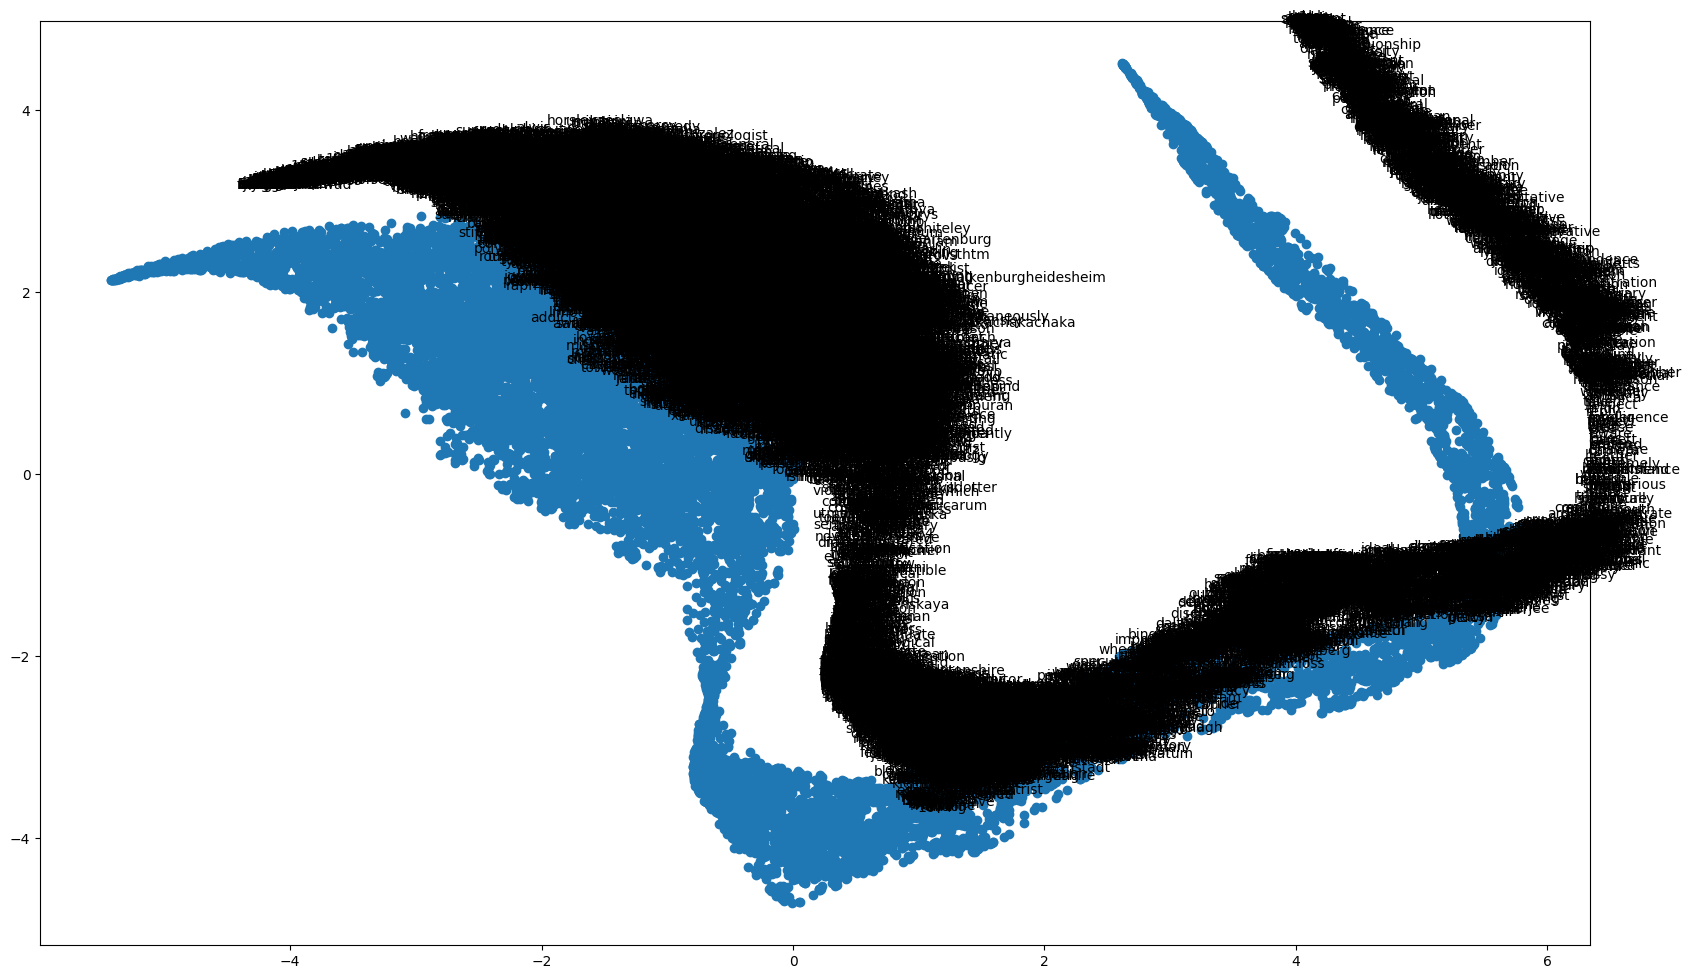

In [186]:
# Visualizing the data points and embeddings
#Visualizing the data points and embeddings

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
words = word_vectors.index_to_key
wvs = word_vectors[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=250, perplexity=5)
tsne_model = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 12))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])

for label, x, y in zip(labels, tsne_model[:, 0], tsne_model[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [187]:
# Crear una representación vectorial promedio para cada texto
X_train_w2v = [word_vectors[word].mean(axis=0) for word in X_train]
X_test_w2v = [word_vectors[word].mean(axis=0) for word in X_test]

# Entrenar un modelo de clasificación (por ejemplo, Regresión Logística)
model = LogisticRegression()
model.fit(X_train_w2v, y_train)

# Evaluar el modelo en el conjunto de prueba
accuracy = model.score(X_test_w2v, y_test)
print(f"Accuracy: {accuracy}")

KeyError: "Key 'waite' not present"

#### ÚLTIMA PROVA

##### kaggle tutorial 
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial


In [408]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [409]:
# Entrenar el modelo word2vec
word2vec_model = Word2Vec(vector_size=300, 
                          window=2, 
                          min_count=20, 
                          sample=6e-5, 
                          workers=cores-1, 
                          sg=1)

In [416]:
# Building the Vocabulary Table
sentences = train_df_clean['lemmatize_word_pos']
word2vec_model.build_vocab(sentences)

In [417]:
# Training of the model
word2vec_model.train(sentences, 
                     total_examples=word2vec_model.corpus_count, # 2000: len(sentences)
                     epochs=30, 
                     report_delay=1)

(637587, 4264350)

- Número de palabras procesadas y el número total de tokens en tu conjunto de datos durante el entrenamiento.

Vectorización del texto: 

In [427]:
def get_average_sentence_vector(sentences):
    sentence_vectors = [get_sentence_vector(sentence) for sentence in sentences]
    if sentence_vectors:
        return np.mean(sentence_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def embed_data_with_sentence_vector(sentences, word2vec):
    embedded_mean = []
    
    for sentence in sentences:
        sentence_vector = get_average_sentence_vector(sentence)
        if np.any(sentence_vector):
            embedded_mean.append(sentence_vector)
    
    return embedded_mean



In [428]:
embedded_mean = embed_data_with_sentence_vector(sentences, word2vec_model)


In [430]:
len(embedded_mean)

2000

- Las dimensiones de embedded_mean coinciden con el número de filas en X_train, ya que cada elemento de embedded_mean corresponderá a una muestra en el mismo orden.

### Creación de X_train

Combinamos embedded_mean con las features adicionales, como las columnas de desplazamiento (Pronoun-offset, A-offset y B-offset), y las características codificadas de los nombres A y B (A y B) y Pronoun.

In [439]:
# Obtener las características adicionales
pronoun_offset = np.array(train_df['Pronoun-offset'])
a_offset = np.array(train_df['A-offset'])
b_offset = np.array(train_df['B-offset'])

# Convertir las características adicionales en vectores de desplazamiento normalizados
normalized_pronoun_offset = pronoun_offset / len(embedded_mean)
normalized_a_offset = a_offset / len(embedded_mean)
normalized_b_offset = b_offset / len(embedded_mean)

# Obtener las representaciones vectoriales para Pronoun, A y B (si están disponibles)
pronoun_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['Pronoun']]
a_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['A']]
b_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['B']]

# Combinar las características en una matriz de características
X_train = np.column_stack((embedded_mean, normalized_pronoun_offset, normalized_a_offset, normalized_b_offset, a_vector, b_vector))


In [440]:
len(X_train)

2000

##### KAGGLE word2vec  
- https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z/notebook


In [396]:

# Entrenar el modelo word2vec
word2vec_model = Word2Vec(sentences = train_df_clean['lemmatize_word_pos'], 
                          vector_size=300, 
                          window=5, 
                          min_count=5, 
                          workers=8, 
                          sg=1)

#word2vec_model.build_vocab(sentences)


def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

embeddings_word2vec = get_embeddings(word2vec_model.wv, # word vectors
                                     train_df_clean['lemmatize_word_pos'], 
                                     k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("The sentence: \"%s\" got embedding values: " % train_df_clean['lemmatize_word_pos'][0])
print(embeddings_word2vec[0])

Embedding matrix size 2000 300
The sentence: "['zoe', 'telford', 'play', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'sleep', 'with', 'jenny', 'and', 'be', 'not', 'see', 'again', 'phoebe', 'thomas', 'play', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realise', 'this', 'be', 'due', 'to', 'him', 'catch', 'crab', 'off', 'her', 'friend', 'pauline']" got embedding values: 
[ 3.46879815e-02  6.41484178e-02 -5.10980130e-02 -7.80474577e-03
 -2.58467493e-02 -1.08373051e-01  4.15540923e-02  2.23118470e-01
  1.77645665e-02 -2.74709153e-02  5.80969923e-02 -6.40902953e-02
 -6.39885268e-02  8.74992634e-02 -2.71428943e-02 -9.30496280e-02
  8.51596153e-02 -3.79004422e-02  1.66125427e-02 -6.6

- It seems like you have successfully obtained the word embeddings for your sentences using Word2Vec. The embedding matrix has a size of 2000 rows (corresponding to the number of sentences) and 300 columns (representing the embedding dimensions).

- The sentence you provided, "['zoe', 'telford', 'play', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'sleep', 'with', 'jenny', 'and', 'be', 'not', 'see', 'again', 'phoebe', 'thomas', 'play', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realise', 'this', 'be', 'due', 'to', 'him', 'catch', 'crab', 'off', 'her', 'friend', 'pauline']," has been transformed into an embedding vector of length 300.

In [397]:
len(embeddings_word2vec)

2000

In [398]:
model_log_reg_2 = sklearn.linear_model.LogisticRegression(multi_class='ovr', max_iter=500)

In [404]:
# Entrenar el modelo
model_log_reg_2.fit(embeddings_word2vec, y_train)

LogisticRegression(max_iter=500, multi_class='ovr')

In [405]:
model_log_reg_2.score(embeddings_word2vec, y_train)

0.526

##### Classe hands on

In [386]:
# Crear una lista de oraciones tokenizadas y lematizadas
sentences = train_df_clean['lemmatize_word_pos'].tolist()

# Entrenar el modelo word2vec
#model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=8, sg=1)
model = Word2Vec(vector_size=300, window=5, min_count=5, workers=8, sg=1)

model.build_vocab(sentences)

In [283]:
model.corpus_count
len(model.wv.key_to_index)

3336

In [284]:
model.train(sentences, epochs = 10, total_examples=len(sentences))

(821072, 1421450)

In [285]:
model.wv.get_vector("magic").shape

(300,)

In [286]:
def embed_data(x_processed_train, word2vec):
    embedded_mean = []
    
    for sentence in x_processed_train:
        embedded_sentence = []
        for token in sentence:
            if token in word2vec.wv:
                embedded_token = word2vec.wv[token]
                embedded_sentence.append(embedded_token)
        
        if embedded_sentence:
            mean_embedding = np.mean(embedded_sentence, axis=0)
            embedded_mean.append(mean_embedding)
    
    return embedded_mean

embedded_mean = embed_data(sentences, model)


In [212]:
tokenized_corpus

[['The', 'rose', 'is', 'red', '.'],
 ['The', 'violet', 'is', 'blue', '.'],
 ['This', 'is', 'some', 'text', ',', 'just', 'for', 'demonstration']]

In [291]:
len(embedded_mean)

2000

In [288]:
model_log_reg = sklearn.linear_model.LogisticRegression(multi_class='ovr', max_iter=500)

In [353]:
# Entrenar el modelo
model_log_reg.fit(embedded_mean, y_train)

LogisticRegression(max_iter=500, multi_class='ovr')

In [354]:
model_log_reg.score(embedded_mean, y_train)

0.533

In [355]:
len(y_train)

2000

##### prova models

In [377]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Preparar los datos
sentences = train_df['lemmatize_word_pos'].tolist()
target = train_df['target'].tolist()

# Entrenar el modelo Word2Vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Obtener las características de Word2Vec
word_features = []

for sentence in sentences:
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        avg_vector = sum(word_vectors) / len(word_vectors)
        word_features.append(avg_vector)
    else:
        word_features.append(np.zeros(model.vector_size))

# Convertir las características a un array numpy
X = np.array(word_features)
y = np.array(target)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [378]:
# Crear el modelo de regresión logística multiclase
model = LogisticRegression(multi_class='ovr', max_iter=500)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.25      0.32       177
           1       0.47      0.75      0.58       186
           2       0.00      0.00      0.00        37

    accuracy                           0.46       400
   macro avg       0.30      0.33      0.30       400
weighted avg       0.41      0.46      0.41       400



/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

In [381]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.43      0.46       177
           1       0.45      0.48      0.47       186
           2       0.09      0.11      0.10        37

    accuracy                           0.42       400
   macro avg       0.34      0.34      0.34       400
weighted avg       0.43      0.42      0.43       400



In [384]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Crear el modelo XGBoost
model = xgb.XGBClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.49      0.55      0.52       177
           1       0.52      0.54      0.53       186
           2       0.12      0.03      0.04        37

    accuracy                           0.50       400
   macro avg       0.38      0.37      0.36       400
weighted avg       0.47      0.50      0.48       400



##### Tutorial 

In [147]:
document = ["The rose is red.", "The violet is blue.", "This is some text, just for demonstration"]

tokenized_corpus = [nltk.word_tokenize(doc) for doc in document]

# Parameters of word2vec model:
# feature_size : integer   :  Word vector dimensionality
# window_context : integer :  The maximum distance between the current and predicted word within a sentence.(2, 10)
# min_word_count : integer : Ignores all words with total absolute frequency lower than this - (2, 100)
# sample : integer  : The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# sg: integer: Skip-gram model configuration, CBOW by default

wordtovector = word2vec.Word2Vec(tokenized_corpus,  
                                 window = 3, # look at 3 words at a time
                                 min_count = 1, # how many times the word needs to appear to be considered by the model
                                 sg = 1 # we are looking at 1 gram at a time
                                 )

vector_size=100, seed=1, sg=1, min_count=0, window=5

In [148]:
print('Embedding of the word blue')
print(wordtovector.wv['blue'])

print('Size of Embedding of the word blue')
print(wordtovector.wv['blue'].shape)


Embedding of the word blue
[ 7.0882346e-03 -1.5676114e-03  7.9485076e-03 -9.4885454e-03
 -8.0291154e-03 -6.6414163e-03 -4.0035523e-03  4.9901577e-03
 -3.8140814e-03 -8.3210431e-03  8.4121935e-03 -3.7481315e-03
  8.6085498e-03 -4.8952354e-03  3.9191796e-03  4.9230848e-03
  2.3934911e-03 -2.8181269e-03  2.8488627e-03 -8.2567511e-03
 -2.7654322e-03 -2.5917992e-03  7.2503299e-03 -3.4646816e-03
 -6.5993182e-03  4.3409867e-03 -4.7505580e-04 -3.5972681e-03
  6.8826573e-03  3.8732658e-03 -3.8993151e-03  7.7144918e-04
  9.1439383e-03  7.7544525e-03  6.3626464e-03  4.6678665e-03
  2.3853814e-03 -1.8410536e-03 -6.3705896e-03 -3.0080325e-04
 -1.5646024e-03 -5.7308871e-04 -6.2642256e-03  7.4344161e-03
 -6.5921969e-03 -7.2388030e-03 -2.7566419e-03 -1.5156541e-03
 -7.6359692e-03  6.9847691e-04 -5.3255404e-03 -1.2766641e-03
 -7.3655383e-03  1.9610589e-03  3.2732745e-03 -2.2214423e-05
 -5.4476624e-03 -1.7254592e-03  7.0852269e-03  3.7373151e-03
 -8.8824788e-03 -3.4133841e-03  2.3537194e-03  2.1375753e-

In [149]:
# All the vectors for all the words in our input text
words = wordtovector.wv.index_to_key
wvs = wordtovector.wv[words]
wvs

array([[-5.3638243e-04,  2.3663162e-04,  5.1046940e-03, ...,
        -7.0424653e-03,  9.0095052e-04,  6.3923588e-03],
       [-8.6196875e-03,  3.6657380e-03,  5.1898835e-03, ...,
        -2.3915148e-03, -9.5100943e-03,  4.5058788e-03],
       [ 9.4563962e-05,  3.0773198e-03, -6.8126451e-03, ...,
         5.1259040e-04,  8.2130842e-03, -7.0190406e-03],
       ...,
       [ 9.7702928e-03,  8.1651136e-03,  1.2809718e-03, ...,
        -2.9727400e-03, -4.9318983e-03, -2.3151112e-03],
       [-1.9442164e-03, -5.2675214e-03,  9.4471136e-03, ...,
         5.9827138e-03,  6.8153618e-03,  7.8225443e-03],
       [-9.5001198e-03,  9.5622232e-03, -7.7707553e-03, ...,
        -3.1351077e-03, -6.3388194e-03,  9.8700775e-03]], dtype=float32)

In [150]:
df = pd.DataFrame(wvs, index = words)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
is,-0.000536,0.000237,0.005105,0.009009,-0.009303,-0.007118,0.006459,0.008974,-0.005016,-0.003765,...,0.001632,0.000190,0.003474,0.000218,0.009618,0.005061,-0.008916,-0.007042,0.000901,0.006392
.,-0.008620,0.003666,0.005190,0.005742,0.007467,-0.006168,0.001106,0.006047,-0.002840,-0.006174,...,0.001088,-0.001576,0.002197,-0.007882,-0.002717,0.002663,0.005347,-0.002392,-0.009510,0.004506
The,0.000095,0.003077,-0.006813,-0.001375,0.007669,0.007346,-0.003673,0.002643,-0.008317,0.006205,...,-0.004509,0.005702,0.009180,-0.004100,0.007965,0.005375,0.005879,0.000513,0.008213,-0.007019
demonstration,-0.008243,0.009299,-0.000198,-0.001967,0.004604,-0.004095,0.002743,0.006940,0.006065,-0.007511,...,-0.007426,-0.001064,-0.000795,-0.002563,0.009683,-0.000459,0.005874,-0.007448,-0.002506,-0.005550
for,-0.007139,0.001241,-0.007177,-0.002245,0.003719,0.005833,0.001198,0.002103,-0.004110,0.007225,...,0.003137,-0.004713,0.005281,-0.004233,0.002642,-0.008046,0.006210,0.004819,0.000787,0.003013
just,-0.008727,0.002130,-0.000874,-0.009319,-0.009428,-0.001411,0.004432,0.003704,-0.006499,-0.006873,...,0.009071,0.008938,-0.008208,-0.003012,0.009887,0.005104,-0.001588,-0.008692,0.002962,-0.006676
",",0.008132,-0.004457,-0.001068,0.001006,-0.000191,0.001148,0.006114,-0.000020,-0.003246,-0.001511,...,-0.002701,0.000444,-0.003537,-0.000419,-0.000709,0.000823,0.008195,-0.005737,-0.001660,0.005572
text,0.008168,-0.004443,0.008985,0.008254,-0.004435,0.000303,0.004274,-0.003926,-0.005560,-0.006512,...,0.002058,-0.004004,-0.008241,0.006278,-0.001949,-0.000666,-0.001771,-0.004536,0.004062,-0.004270
some,-0.009579,0.008943,0.004165,0.009235,0.006644,0.002925,0.009804,-0.004425,-0.006803,0.004227,...,-0.005085,0.001131,0.002883,-0.001536,0.009932,0.008350,0.002416,0.007118,0.005891,-0.005581
This,-0.005157,-0.006668,-0.007777,0.008311,-0.001982,-0.006855,-0.004154,0.005144,-0.002869,-0.003750,...,-0.008977,0.008592,0.004047,0.007469,0.009746,-0.007290,-0.009040,0.005836,0.009391,0.003507


In [151]:
# word2vec representation allows us to compute similarity in terms of 
# cosine similarity metric between the word vectors in the embedding space.

#Similarity Matrix
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,is,.,The,demonstration,for,just,",",text,some,This,blue,violet,red,rose
is,1.000000,-0.010757,-0.052358,-0.111662,-0.027774,-0.059873,0.016129,0.092916,0.027063,0.216162,0.062931,0.079646,0.093112,-0.041240
.,-0.010757,1.000000,-0.023672,0.067976,0.004503,0.009391,-0.114107,-0.115555,0.033641,-0.095716,-0.134190,0.008316,-0.003644,0.137253
The,-0.052358,-0.023672,1.000000,-0.013515,0.170189,0.064090,0.145951,-0.002754,0.199121,-0.032844,-0.101988,0.172728,0.046526,-0.135392
demonstration,-0.111662,0.067976,-0.013515,1.000000,-0.044617,0.131490,0.041577,-0.013680,0.074976,-0.169368,0.012988,0.041308,-0.009253,0.006598
for,-0.027774,0.004503,0.170189,-0.044617,1.000000,0.138880,0.034765,-0.028491,-0.069003,-0.173234,-0.258891,-0.005897,0.150165,0.252905
just,-0.059873,0.009391,0.064090,0.131490,0.138880,1.000000,0.019152,-0.057746,0.060592,-0.105138,0.020002,0.166947,-0.145108,0.044107
",",0.016129,-0.114107,0.145951,0.041577,0.034765,0.019152,1.000000,0.004842,0.008826,0.001947,0.050470,-0.083826,0.000731,0.012812
text,0.092916,-0.115555,-0.002754,-0.013680,-0.028491,-0.057746,0.004842,1.000000,-0.144546,-0.093274,0.108879,0.111180,-0.040905,-0.025461
some,0.027063,0.033641,0.199121,0.074976,-0.069003,0.060592,0.008826,-0.144546,1.000000,0.044691,0.026811,0.037713,-0.040441,-0.122462
This,0.216162,-0.095716,-0.032844,-0.169368,-0.173234,-0.105138,0.001947,-0.093274,0.044691,1.000000,0.015009,-0.074243,-0.045690,-0.106194


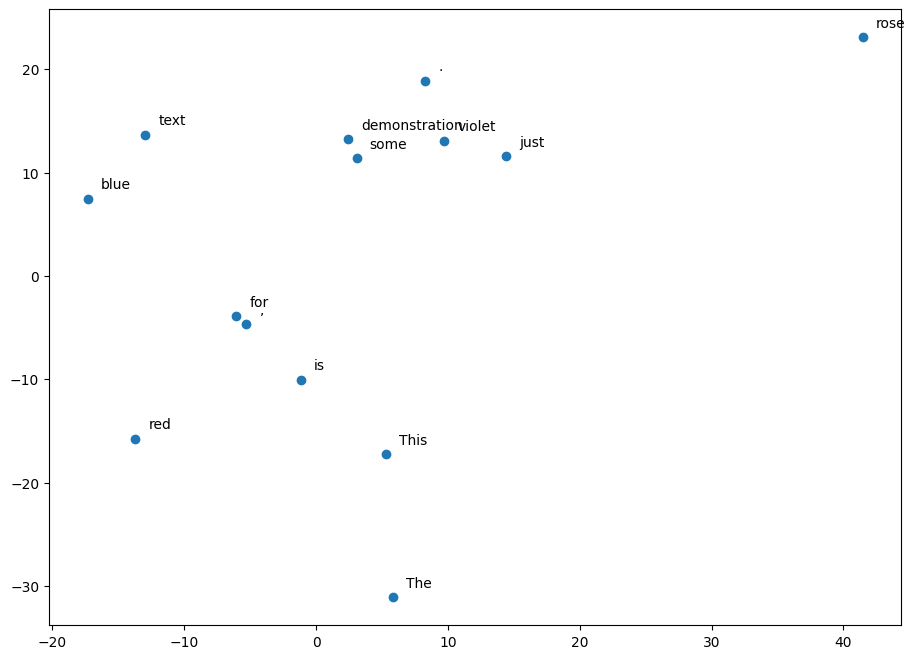

In [153]:
# Visualizing the data points and embeddings
#Visualizing the data points and embeddings

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


words = wordtovector.wv.index_to_key
wvs = wordtovector.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=250, perplexity=5)
tsne_model = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(11, 8))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])

for label, x, y in zip(labels, tsne_model[:, 0], tsne_model[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Countverctorizer of TF-IDF FER PROVA TB AMB AQUEST PQ NSE QUIN S'HA DE FER SI AQUEST O EL WORD 2 VEC

- https://www.youtube.com/watch?v=E0b_iqPXr7g&list=PLVcEZG2JPVhczW3ahebNo_AXB1NI3urgn&index=3
min 34

In [367]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir los datos en conjuntos de entrenamiento y prueba
X = train_df['lemmatize_word_pos']
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crear un vectorizador de Bag-of-Words
vectorizer = CountVectorizer()

# Convertir las secuencias de palabras lematizadas en características numéricas
X_train_combined = [' '.join(doc) for doc in X_train]
X_train_vectorized = vectorizer.fit_transform(X_train_combined)
X_test_combined = [' '.join(doc) for doc in X_test]
X_test_vectorized = vectorizer.transform(X_test_combined)

# Crear el modelo de regresión logística
model = LogisticRegression(multi_class='ovr', max_iter=500)

# Entrenar el modelo
model.fit(X_train_vectorized, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_vectorized)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.54      0.51       177
           1       0.51      0.54      0.52       186
           2       0.44      0.11      0.17        37

    accuracy                           0.50       400
   macro avg       0.48      0.39      0.40       400
weighted avg       0.49      0.50      0.49       400



### Converting target to binary

- Debemos codificar las etiquetas de clase de las variables objetivo (A-coref y B-coref) para asegurar la compatibilidad con los modelos.
-  Dabido a que tenemos clases binarias, usaremos el LabelEncoder:
    - False = 0
    - True = 1


In [293]:
import sklearn
from sklearn import preprocessing

In [294]:
def encode_target(df, target_1="A-coref", target_2="B-coref"):
    le = preprocessing.LabelEncoder()
    df[target_1] = le.fit_transform(df[target_1])
    df[target_2] = le.fit_transform(df[target_2])
    return df

In [314]:
train_df = encode_target(train_df, target_1="A-coref", target_2="B-coref")

In [315]:
train_df['A-coref'].value_counts()

A-coref
0    1126
1     874
Name: count, dtype: int64

In [316]:
train_df['B-coref'].value_counts()

B-coref
0    1075
1     925
Name: count, dtype: int64

### Añadir 3a condición: A-coref = False y B-coref = False

Puede haber casos en los que la respuesta sea A-coref == False y B-coref == False, lo que indica que el pronombre no hace referencia a ninguno de los nombres propuestos. 

In [330]:
if (~(train_df['A-coref'] | train_df['B-coref'])).any():
    print("Existe al menos una fila donde A-coref y B-coref son ambos 0.")
else:
    print("No existe ninguna fila donde A-coref y B-coref sean ambos 0.")

Existe al menos una fila donde A-coref y B-coref son ambos 0.


Por otro lado, no puede haber casos en los que la respuesta sea A-coref == True y B-coref == True:

In [331]:
if (train_df['A-coref'] & train_df['B-coref']).any():
    print("Existe al menos una fila donde A-coref y B-coref son ambos 1.")
else:
    print("No existe ninguna fila donde A-coref y B-coref sean ambos 1.")

No existe ninguna fila donde A-coref y B-coref sean ambos 1.


En base a la representación de tu variable objetivo `y_train`, parece que estás utilizando un enfoque de codificación one-hot para representar las clases "A-coref" y "B-coref". El arreglo muestra dos columnas, donde la primera columna representa la clase "A-coref" y la segunda columna representa la clase "B-coref".

Sin embargo, noto que tienes algunos casos en los que ambas columnas tienen valores 0, lo cual indica que el pronombre no hace referencia a ninguno de los nombres propuestos.

Dado que tienes esta situación donde el pronombre no se refiere a ningún nombre, te sugiero incluir una tercera clase adicional para representar esta situación. Por ejemplo, puedes agregar una tercera columna que indique la clase "None" cuando ambas columnas "A-coref" y "B-coref" sean 0.

El arreglo `y_train` se vería así:

```
array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])
```

Aquí, la tercera columna representa la clase "None". Si ambas columnas "A-coref" y "B-coref" son 0, entonces la tercera columna correspondiente a "None" tendría el valor 1.

Al ajustar tu modelo de regresión logística, ahora estarías trabajando con una clasificación de tres clases: "A-coref", "B-coref" y "None". Asegúrate de actualizar el modelo y las métricas de evaluación para adaptarse a esta configuración de clasificación de tres clases.

In [318]:
# Obtener las columnas A-coref y B-coref del dataset de entrenamiento
a_coref = train_df['A-coref'].values
b_coref = train_df['B-coref'].values

# Crear la tercera columna para representar la clase "None"
none_coref = np.where((a_coref == 0) & (b_coref == 0), 1, 0)

# Agregar la columna "None-coref" al dataset de entrenamiento
train_df['None-coref'] = none_coref


In [320]:
train_df['None-coref'].value_counts()

None-coref
0    1799
1     201
Name: count, dtype: int64

- Hay 201 casos en los que el pronombre no hace referencia a ninguno de los nombres propuestos.

In [324]:
# casos en los que el pronombre no hace referencia a ninguno de los nombres propuestos
train_df[train_df['None-coref']==1][['A-coref','B-coref','None-coref']]

,A-coref,B-coref,None-coref
6,0,0,1
15,0,0,1
17,0,0,1
28,0,0,1
31,0,0,1
...,...,...,...
1961,0,0,1
1983,0,0,1
1985,0,0,1
1986,0,0,1


In [321]:
train_df[['A-coref','B-coref','None-coref']]

,A-coref,B-coref,None-coref
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1995,0,1,0
1996,0,1,0
1997,1,0,0
1998,1,0,0


- Ahora tenemos 3 variables objetivo: "A-coref", "B-coref" y "None-coref". Cada instancia tiene un valor de 1 en una de las columnas correspondientes a la variable objetivo y un valor de 0 en las otras dos columnas.



### Crear columna target 

- Creamos la columna target definitiva donde asignamos:
    - `0`: si el pronombre hace referencia al nombre A.
    - `1`: si el pronombre hace referencia al nombre B.
    - `2`: si el pronombre no hace referencia a ninguno de los dos nombres propuestos. 

In [332]:
# Crear la columna target
def get_target(row):
    if row['A-coref'] == 1:
        return 0
    elif row['B-coref'] == 1:
        return 1
    else:
        return 2

In [ ]:
# Creamos la columna target
train_df['target'] = train_df.apply(get_target, axis=1)

In [333]:
train_df[['A-coref','B-coref','None-coref', 'target']]

,A-coref,B-coref,None-coref,target
0,1,0,0,0
1,1,0,0,0
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
1995,0,1,0,1
1996,0,1,0,1
1997,1,0,0,0
1998,1,0,0,0


In [334]:
train_df[train_df['None-coref']==1][['A-coref','B-coref','None-coref', 'target']]

,A-coref,B-coref,None-coref,target
6,0,0,1,2
15,0,0,1,2
17,0,0,1,2
28,0,0,1,2
31,0,0,1,2
...,...,...,...,...
1961,0,0,1,2
1983,0,0,1,2
1985,0,0,1,2
1986,0,0,1,2


In [337]:
# 3 clases
train_df['target'].value_counts()

target
1    925
0    874
2    201
Name: count, dtype: int64

- 874 instancias donde el pronombre hace referencia al nombre A.
- 925 instancias donde el pronombre hace referencia al nombre B.
- 201 instancias donde el pronombre no hace referencia a ninguno de los dos nombres propuestos.

## xtrain y train

In [ ]:
# X_train = train_df[imp_features]
# y_train = train_df[target]

In [401]:
y_train = train_df['target'].values.astype(int)



In [402]:
y_train

array([0, 0, 1, ..., 0, 0, 1])

In [403]:
len(y_train)

2000

In [ ]:
# features (train dataset)
X_train

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset
0,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207
1,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251
2,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246
3,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294
...,...,...,...,...,...,...,...
1995,"Faye's third husband, Paul Resnick, reported t...",her,433,Nicole,255,Faye,328
1996,The plot of the film focuses on the life of a ...,her,246,Doris Chu,111,Mei,215
1997,Grant played the part in Trevor Nunn's movie a...,she,348,Maria,259,Imelda Staunton,266
1998,The fashion house specialised in hand-printed ...,She,284,Helen,145,Suzanne Bartsch,208


In [ ]:
# target (train dataset)
y_train

,A-coref,B-coref
0,True,False
1,True,False
2,False,True
3,False,True
4,False,True
...,...,...
1995,False,True
1996,False,True
1997,True,False
1998,True,False


- Puede haber casos en los que la respuesta sea A-coref == False y B-coref == False, lo que indica que el pronombre no hace referencia a ninguno de los nombres propuestos. 

## Test preprocessing

In [474]:
# Text Cleaning Functions

def select_imp_features(df):
    imp_features = ["Text", "Pronoun", "Pronoun-offset", "A", "A-offset", "B", "B-offset"]
    target_col = ["A-coref", "B-coref"]
    df = df[imp_features + target_col]
    return df 

def lower_case(df):
    df.loc[:, "text_clean"] = df["Text"].apply(lambda x: x.lower())
    df.loc[:, "Pronoun"] = df["Pronoun"].apply(lambda x: x.lower())
    df.loc[:, "A"] = df["A"].apply(lambda x: x.lower())
    df.loc[:, "B"] = df["B"].apply(lambda x: x.lower())

def expand_contractions(df):
    df.loc[:, "text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))

def remove_non_ascii_characters(df, col='text_clean'):
    df.loc[:, col] = df[col].apply(lambda text: re.sub(r'[^\x00-\x7f]', r'', text)) # get rid of non-characters and whitespace
    return df

def remove_punctuations(df, col='text_clean'):
    """
     - str.maketrans('', '', string.punctuation) crea un traductor utilizando maketrans 
       que mapea los caracteres de puntuación a None, es decir, los elimina.
     - string.punctuation es una cadena predefinida en el módulo string que contiene todos 
       los caracteres de puntuación.
     - text.translate(translator) aplica el traductor al texto, reemplazando las puntuaciones 
       con caracteres vacíos, lo que efectivamente las elimina.
    """
    df.loc[:, col] = df[col].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    # return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return df

# Orquestación secuencial de la limpieza de texto
def text_cleaning(df):
    # Crear una copia del DataFrame:
        # todas las modificaciones se realicen en una copia independiente 
        # y no afectan al DataFrame original.
    df = df.copy()  
    # text cleaning functions
    df = select_imp_features(df)
    lower_case(df)
    expand_contractions(df)
    df = remove_non_ascii_characters(df)
    df = remove_punctuations(df)
    return df

In [475]:
test_df_cleaned = text_cleaning(test_df)


In [ ]:
# Text Preprocessing Functions 

# Tokenization
train_df_clean['tokenized'] = train_df_clean['text_clean'].apply(word_tokenize)

# Part of Speech Tagging


# Lemmatization with PoS

In [ ]:
# Celda 2: Definir las funciones de limpieza

def clean_text(text):
    # Funciones de limpieza
    ...

def tokenize_text(text):
    # Funciones de tokenización
    ...

def lemmatize_text(text):
    # Funciones de lematización
    ...

def word2vec_encoding(text):
    # Funciones de encoding con word2vec
    ...

# Celda 3: Preprocesamiento del conjunto de datos de test

def preprocess_test_data(test_data):
    cleaned_data = clean_text(test_data)
    tokenized_data = tokenize_text(cleaned_data)
    lemmatized_data = lemmatize_text(tokenized_data)
    encoded_data = word2vec_encoding(lemmatized_data)

    return encoded_data

# Celda 4: Cargar el conjunto de datos de test y llamar a la función de preprocesamiento

test_data = ...
preprocessed_test_data = preprocess_test_data(test_data)


In [447]:
test_df = text_cleaning(test_df)

## Models 

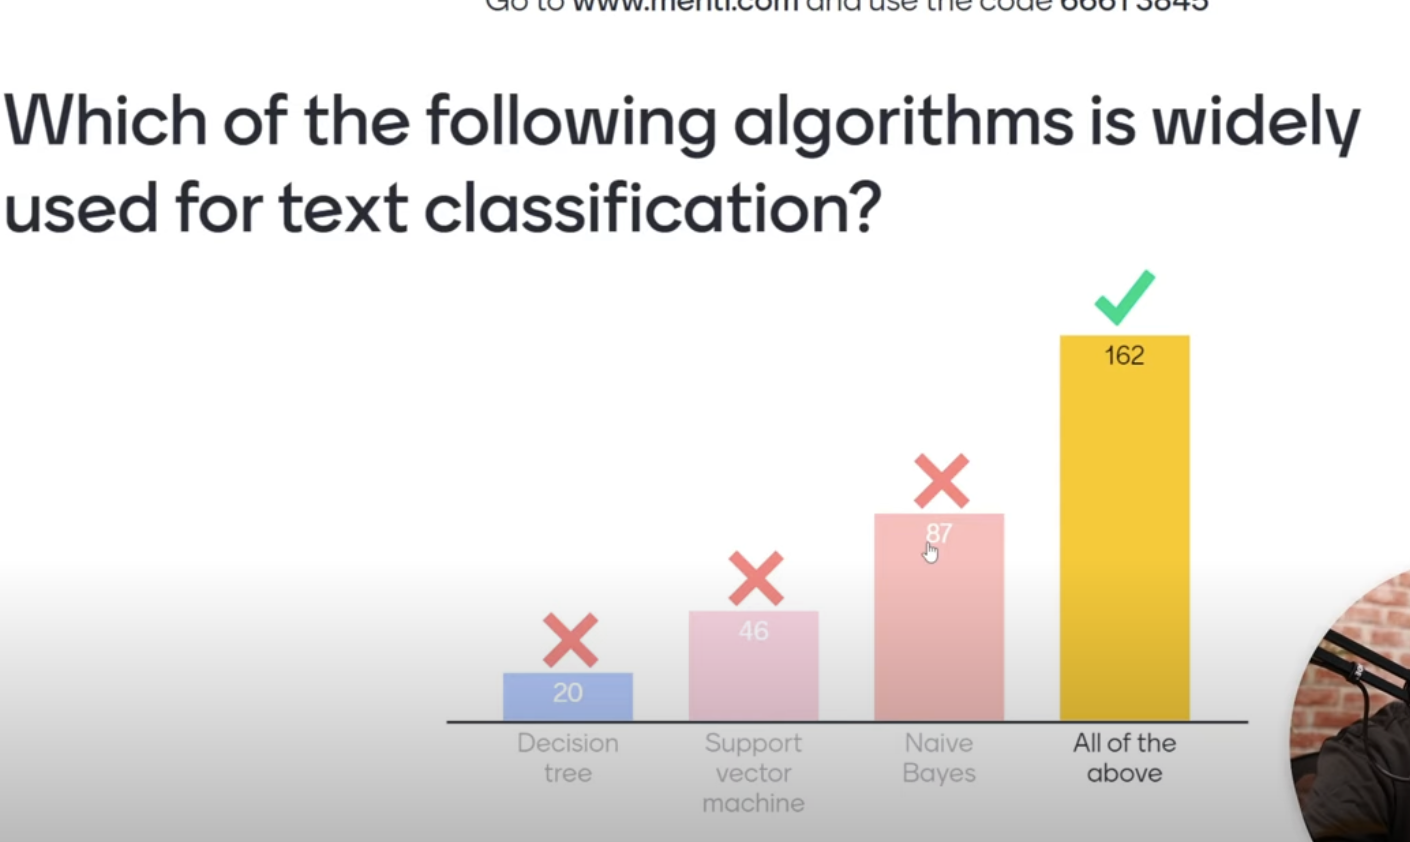